# **Indonesia's Red Chili Pepper Retail Price Analysis**

> *Written by: Azhar Anas*

Red chili pepper (*Cabai Rawit Merah*) is one of the most essential spices in Indonesian cuisine. Known for its fiery taste, it is widely used in various traditional dishes and is almost inseparable from Indonesian dining culture. Its presence is especially significant during special celebrations, communal gatherings, and in countless street food vendors, making it a staple ingredient that strongly represents Indonesian food identity.

With such high demand, red chili pepper has become more than just a cooking ingredient, it is now considered a strategic commodity in Indonesia. Price fluctuations of this commodity can directly impact household spending and food vendors. Therefore, analyzing its retail price over time is crucial to better understand supply-demand dynamics and potential market volatility.

This analysis covers multiple regions across Indonesia, with provinces selected to represent major islands of the archipelago. Specifically, Bali represents the island of Bali, Gorontalo for Sulawesi, Central Java for Java, South Kalimantan for Kalimantan, Papua for Papua, and North Sumatra for Sumatra. By including provinces from different islands, this study aims to capture a comprehensive and strategic overview of chili price behavior across the nation.

The ultimate expectation of this analysis is to provide valuable insights for multiple stakeholders. For farmers, it may serve as a reference to plan cultivation and harvest cycles. For consumers, it can help anticipate price fluctuations and manage household expenses. For the government, these findings can support policy-making and future strategies to stabilize food prices and ensure sustainable food security in Indonesia.

## **0. Import Library**

In [1]:
# Libraries for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)  
from sklearn.preprocessing import MinMaxScaler

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Libraries for LSTM modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Library for hyperparameter tuning
import optuna

# Library for traiing time measurement
import time

# Libraries for model evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Library for saving the scaler
import joblib

# Python version
import sys
print("Python version:", sys.version)

Python version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:42:04) [MSC v.1943 64 bit (AMD64)]


In [2]:
# GPU Memory Limit (comment out if not using GPU)
tf.config.set_logical_device_configuration(
    tf.config.list_physical_devices("GPU")[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=5199)],
)

## **1. Import Dataset**

The Indonesian Retail Commodity Price Dataset used in this analysis was obtained from the [National Food Agency Price Panel](https://panelharga.badanpangan.go.id). The dataset covers the provinces of **Bali**, **Gorontalo**, **Central Java**, **South Kalimantan**, **Papua**, and **North Sumatra**. The data includes various commodities, but for this analysis, the focus will be on the commodity **Red Chili Pepper**, a natural ingredient commonly used in Indonesian cuisine.

This dataset is structured as a **time series** in **daily units**, spanning from **March 2021 to December 2023**. The dataset contains commodity price data recorded in **Indonesian Rupiah (IDR)** and expressed per **kilogram** (IDR/kg).

### **1.1 Read & Prepare Raw Dataset**

In [3]:
# Import Raw Dataset
def read_and_prepare(path):
    df = pd.read_excel(path, header=0, index_col=0).T.replace("-", np.nan)
    df = df.reset_index().rename(columns={'index': 'Tanggal'})
    return df

df_bali = read_and_prepare('dataset/raw/bali.xlsx')
df_gorontalo = read_and_prepare('dataset/raw/gorontalo.xlsx')
df_java = read_and_prepare('dataset/raw/jawa-tengah.xlsx')
df_kalimantan = read_and_prepare('dataset/raw/kalimantan-selatan.xlsx')
df_papua = read_and_prepare('dataset/raw/papua.xlsx')
df_sumatra = read_and_prepare('dataset/raw/sumatra-utara.xlsx')

In [4]:
# Example for Bali
df_bali

Komoditas (Rp),Tanggal,Beras Premium,Beras Medium,Kedelai Biji Kering (Impor),Bawang Merah,Bawang Putih Bonggol,Cabai Merah Keriting,Cabai Rawit Merah,Daging Sapi Murni,Daging Ayam Ras,...,Minyak Goreng Kemasan Sederhana,Tepung Terigu (Curah),Minyak Goreng Kemasan Premium,Minyak Goreng Curah,Jagung Tk Peternak,Ikan Kembung,Ikan Tongkol,Ikan Bandeng,Garam Halus Beryodium,Tepung Terigu Kemasan (non-curah)
0,01/03/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,02/03/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03/03/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,04/03/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,05/03/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,27/12/2023,14.890,13.370,11.520,30.590,33.100,56.950,75.420,118.550,38.720,...,17.420,11.370,NaN,15.100,5.910,41.930,33.370,35.480,12.650,12.320
1032,28/12/2023,14.890,13.360,11.110,32.430,33.650,54.390,75.240,118.550,38.820,...,17.420,11.480,NaN,15.100,5.850,40.820,33.700,37.220,12.650,12.320
1033,29/12/2023,14.890,13.370,11.520,34.330,33.980,53.840,74.430,118.550,38.490,...,17.420,11.480,NaN,15.100,5.970,39.870,33.880,37.220,12.650,12.350
1034,30/12/2023,14.890,13.310,11.520,34.540,33.980,58.070,74.850,118.550,38.830,...,17.420,11.480,NaN,15.100,5.910,38.820,33.220,37.220,12.650,12.470


### **1.2 Merge Only *`Cabai Rawit Merah`* or `Red Chili Pepper` on Every Province**

In [5]:
df_merged = pd.DataFrame()

# Create Date column
df_merged['Date'] = pd.to_datetime(df_bali['Tanggal'], dayfirst=True)

# Merge `Cabai Rawit Merah` column from each dataframe
df_merged['Bali'] = df_bali['Cabai Rawit Merah']
df_merged['Gorontalo'] = df_gorontalo['Cabai Rawit Merah']
df_merged['Central Java'] = df_java['Cabai Rawit Merah']
df_merged['South Kalimantan'] = df_kalimantan['Cabai Rawit Merah']
df_merged['Papua'] = df_papua['Cabai Rawit Merah']
df_merged['North Sumatra'] = df_sumatra['Cabai Rawit Merah']

# Convert all columns except 'Date' to integer, handling thousand separators
for col in df_merged.columns:
    if col != 'Date':
        df_merged[col] = df_merged[col].str.replace('.', '', regex=False)
        df_merged[col] = pd.to_numeric(df_merged[col], errors='coerce').astype('Int64')

df_merged.info()
df_merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1036 non-null   datetime64[ns]
 1   Bali              989 non-null    Int64         
 2   Gorontalo         991 non-null    Int64         
 3   Central Java      993 non-null    Int64         
 4   South Kalimantan  993 non-null    Int64         
 5   Papua             985 non-null    Int64         
 6   North Sumatra     989 non-null    Int64         
dtypes: Int64(6), datetime64[ns](1)
memory usage: 62.9 KB


,Date,Bali,Gorontalo,Central Java,South Kalimantan,Papua,North Sumatra
0,2021-03-01,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2021-03-02,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2021-03-03,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2021-03-04,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2021-03-05,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
...,...,...,...,...,...,...,...
1031,2023-12-27,75420,129660,74910,75710,135340,73480
1032,2023-12-28,75240,124680,74410,64660,139290,68680
1033,2023-12-29,74430,121390,73660,67860,135190,66720
1034,2023-12-30,74850,117580,73170,63010,114200,57690


## **2. Exploratory Data Analysis**

In this stage, time series data analysis is conducted to assess, provide insights, and support decision-making for building the model later. This stage consists of:
- Identify and analyze missing values to understand data completeness and decide on proper handling strategies.
- Detect duplicate records that may introduce bias and ensure data integrity.
- Examine data distribution patterns and identify potential outliers that may distort statistical analysis or modeling.
- Measure the skewness and kurtosis to evaluate whether the data approximates a normal distribution or shows deviations.
- Visualize time series data with line charts to observe trends, seasonality, and fluctuations over time.
- Assess correlations among variables at the current time to uncover potential relationships relevant for MIMO modeling.
- Analyze autocorrelations across different lags to understand dependencies in time series data, which is critical for forecasting models look back/window size.

### **2.1 Missing Values Check**

In [6]:
df_merged.isna().sum()

Date                 0
Bali                47
Gorontalo           45
Central Java        43
South Kalimantan    43
Papua               51
North Sumatra       47
dtype: int64

### **2.2 Duplicate Values Check**

In [7]:
df_merged.duplicated().sum()

0

### **2.3 Data Distribution & Outliers Analysis**

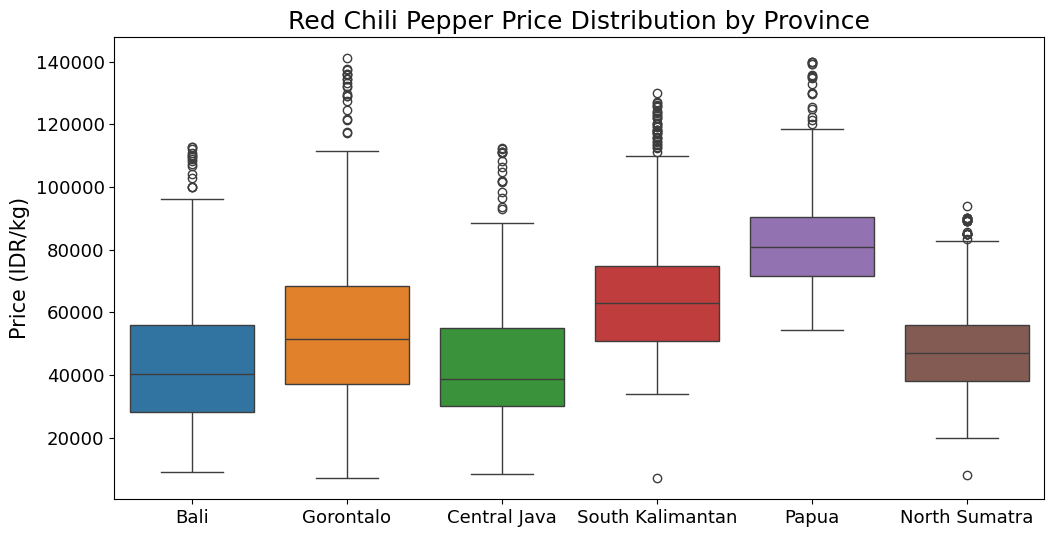

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_merged.drop(columns=['Date']).astype(float))
plt.title('Red Chili Pepper Price Distribution by Province', fontsize=18)
plt.ylabel('Price (IDR/kg)', fontsize=15)
# plt.xlabel('Province', fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(rotation=0, fontsize=13)
plt.show()

**Insight:**
- Papua shows the highest median price (around 80–90k IDR/kg) with wider variability compared to other provinces.  
- Bali and Central Java tend to have lower median prices.  
- All provinces exhibit many **upper outliers** (extreme high prices), indicating periods of price spikes.  
- North Sumatra appears more stable with a narrower price range compared to Gorontalo and Papua.

> In Papua, prices tend to be higher and more volatile, while in North Sumatra they are relatively stable, with Bali and Central Java usually showing lower prices, though all provinces occasionally experience sudden spikes.

### **2.4 Skewness and Kurtosis Analysis**

                  Skewness  Kurtosis
Bali              0.834517  0.339375
Gorontalo         0.947483  1.016133
Central Java      0.979088  0.651420
South Kalimantan  0.944118  0.981633
Papua             0.943359  1.857109
North Sumatra     0.670028  0.378754


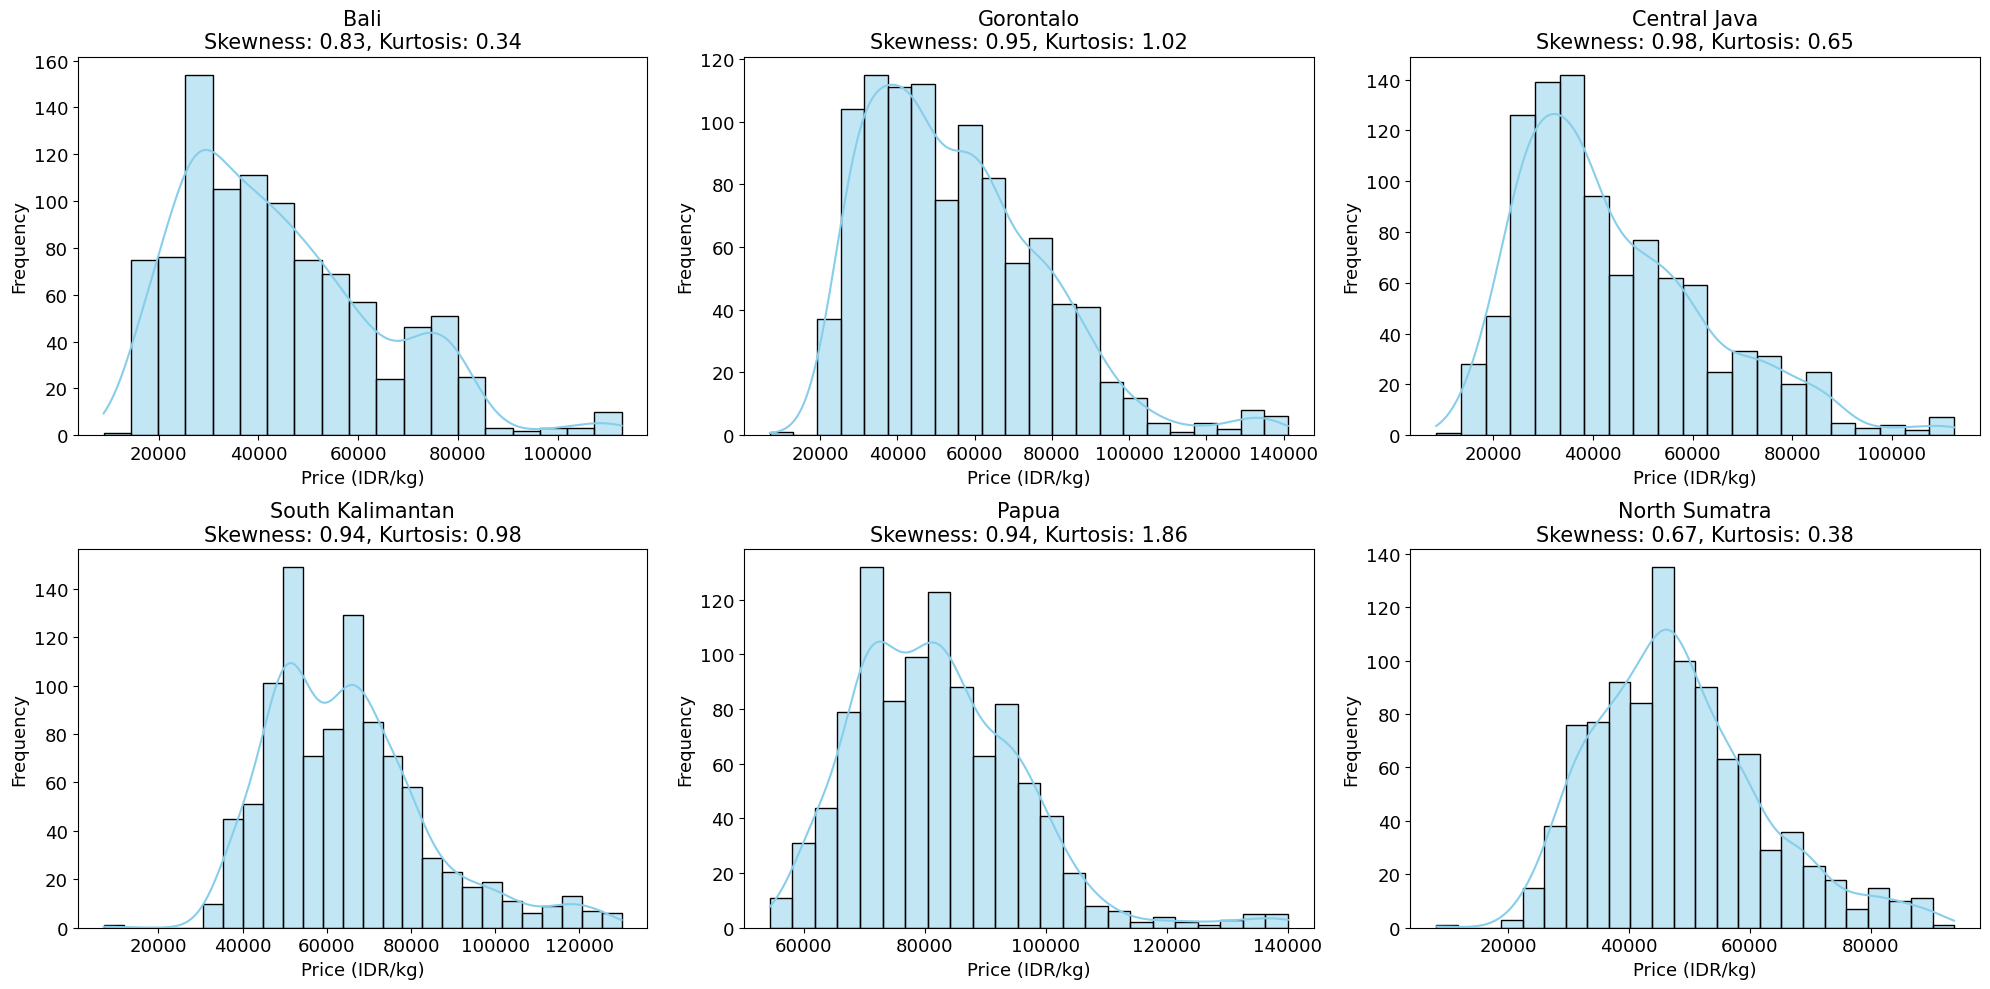

In [9]:
provinces = ['Bali', 'Gorontalo', 'Central Java', 'South Kalimantan', 'Papua', 'North Sumatra']

skewness = df_merged.drop(columns=['Date']).astype(float).skew()
kurtosis = df_merged.drop(columns=['Date']).astype(float).kurtosis()
skew_kurt_df = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})
print(skew_kurt_df)

fig, axes = plt.subplots(2, 3, figsize=(20, 10), sharex=False)
axes = axes.flatten()
for idx, region in enumerate(provinces):
    data = df_merged[region].dropna().astype(float)
    ax = axes[idx]
    sns.histplot(data, kde=True, ax=ax, color='skyblue')
    skew_val = skewness[region]
    kurt_val = kurtosis[region]
    ax.set_title(f'{region}\nSkewness: {skew_val:.2f}, Kurtosis: {kurt_val:.2f}', fontsize=15)
    ax.set_xlabel('Price (IDR/kg)', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)

plt.tight_layout()
plt.show()

**Insight:**
- Most provinces show **positively skewed distributions** → prices are concentrated at lower-to-mid levels with a long tail toward high prices.  
- **Low kurtosis values (0–1)** suggest relatively flatter distributions, except **Papua (kurtosis 1.86)** which is more peaked and influenced by extreme values.  
- **North Sumatra** has the lowest skewness (0.67), meaning a more balanced distribution compared to others.

> In most provinces, chili prices are generally on the lower side but sometimes jump sharply, with Papua being the most prone to extreme price hikes, while North Sumatra shows the most balanced price pattern.

### **2.5 Line Chart Visualization**

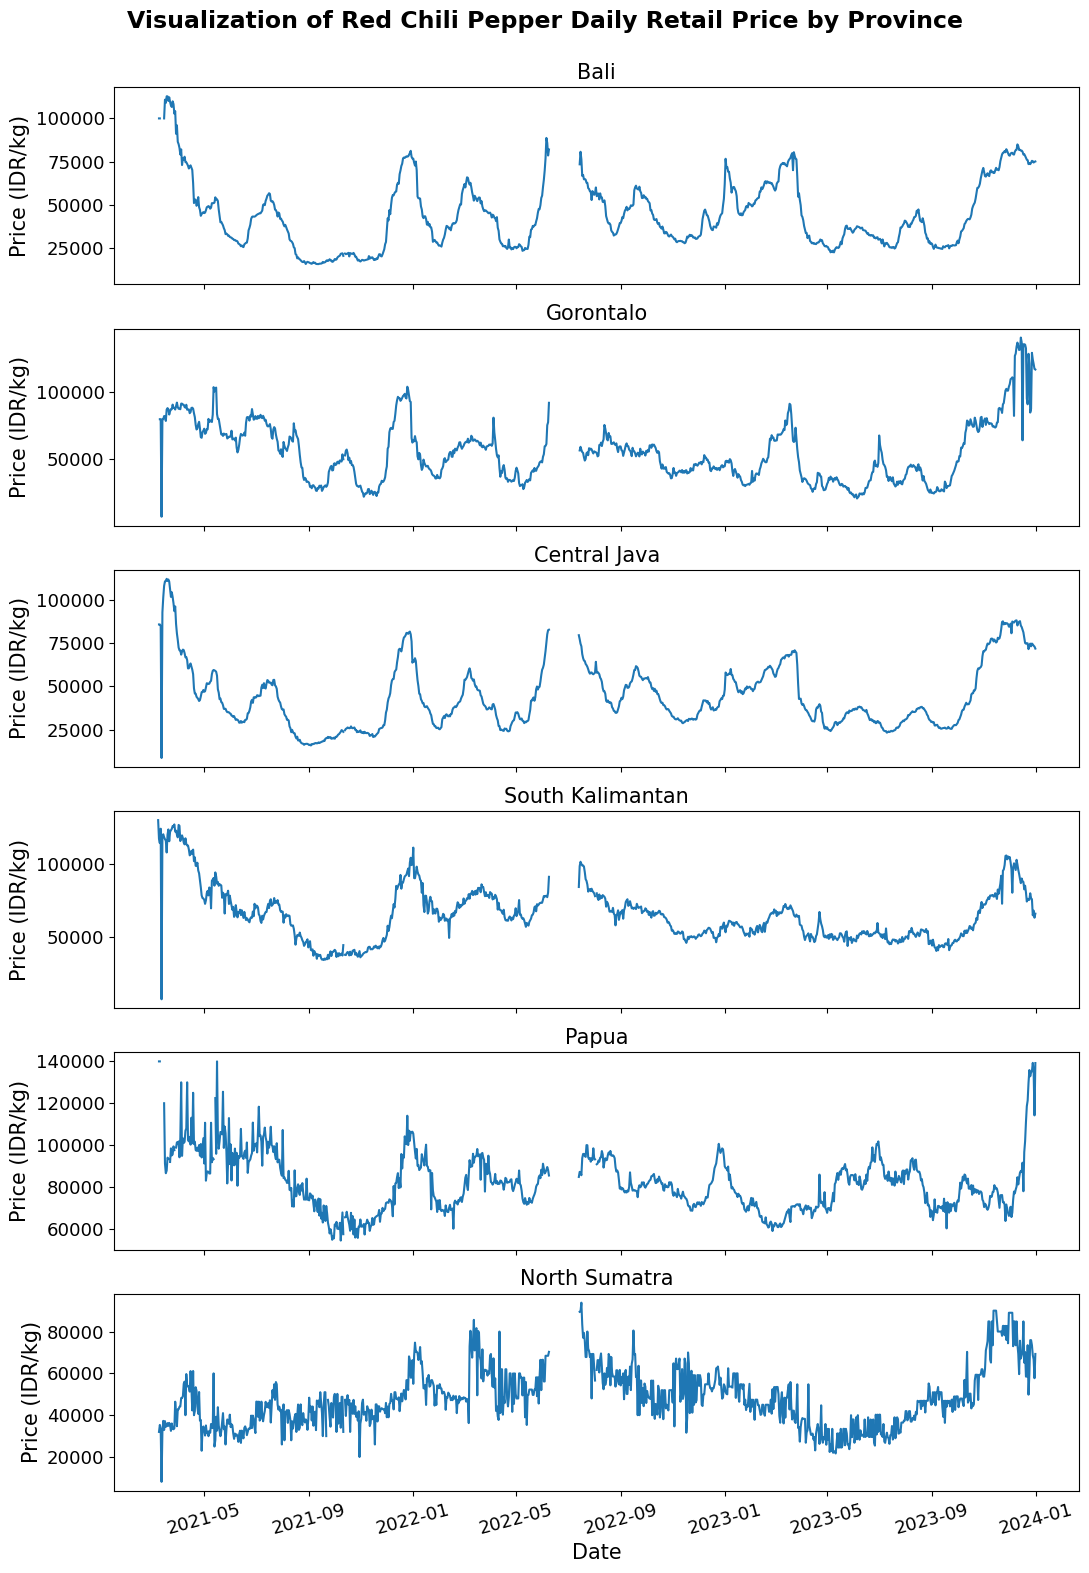

In [10]:
fig, axes = plt.subplots(6, 1, figsize=(11, 16), sharex=True)
fig.suptitle("Visualization of Red Chili Pepper Daily Retail Price by Province", fontsize=17, fontweight="bold")

for i, region in enumerate(provinces):
    axes[i].plot(df_merged['Date'], df_merged[region], label=region)
    axes[i].set_ylabel("Price (IDR/kg)", fontsize=15)
    axes[i].set_title(region, fontsize=15)
    axes[i].tick_params(axis="x", rotation=15, labelsize=13)
    axes[i].tick_params(axis="y", labelsize=13)

axes[-1].set_xlabel("Date", fontsize=15)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Insight:**
- Clear **seasonal fluctuations** with similar patterns across regions, supporting the choice of **MIMO LSTM** since the same commodity shares similar dynamics.  
- **Papua** consistently records higher prices, with a significant spike at the end of 2023.  
- **Bali and Central Java** show very similar cyclical patterns.  
- **Missing values** are observed in all provinces at the beginning of the data and around July 2022.
- **Sudden drops** are observed on 12th March 2021 in all provinces. This can be an error from the system due to the loss of one digit zero.

> Chili prices move in repeating seasonal cycles across all regions, with Papua consistently being the most expensive, Bali and Central Java showing very similar trends, then data gaps appearing in all provinces at the beginning and around July 2022 due to incomplete records from the data source.

### **2.6 `Current Time` Data Correlation Check**

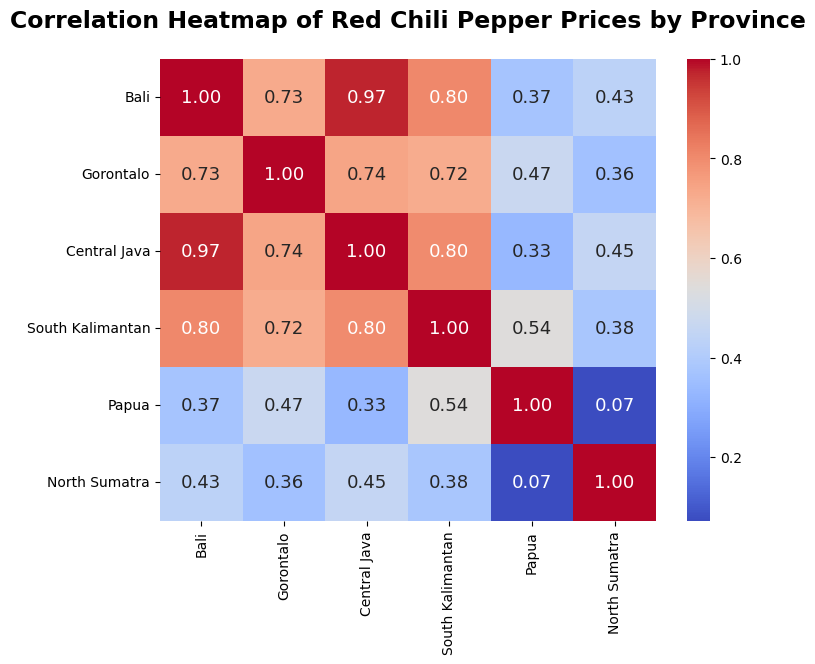

In [11]:
# Pearson Correlation Heatmap used to check correlation between provinces on the same date (current time)
correlation_matrix = df_merged.drop(columns=['Date']).astype(float).corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"fontsize": 13})
plt.title('Correlation Heatmap of Red Chili Pepper Prices by Province', fontsize=17, y=1.05, fontweight='bold')
plt.show()

**Insight:**
- Bali and Central Java show an extremely strong correlation (0.97), indicating their price dynamics move almost identically.
- South Kalimantan also has high correlations with both Bali (0.80) and Central Java (0.80), suggesting they share very similar seasonal and market-driven fluctuations.
- Gorontalo shows a moderately strong correlation with Bali (0.72) and Central Java (0.74), meaning its price pattern is still aligned, though less tightly coupled.
- Papua has weak correlations with other provinces (ranging from 0.33 to 0.54), highlighting its more isolated price behavior and unique market dynamics.
- North Sumatra shows low to moderate correlations (around 0.36–0.45) with most provinces, with the weakest link to Papua (0.07), indicating strong independence in price movements.

> Chili prices in Indonesia display strong regional clustering with provinces in Java and Kalimantan move closely together, while Papua and North Sumatra show more independent trends. This suggests that while some markets are highly interconnected, others operate under distinct local factors.

### **2.7 Autocorrelation Function (ACF) Plot**

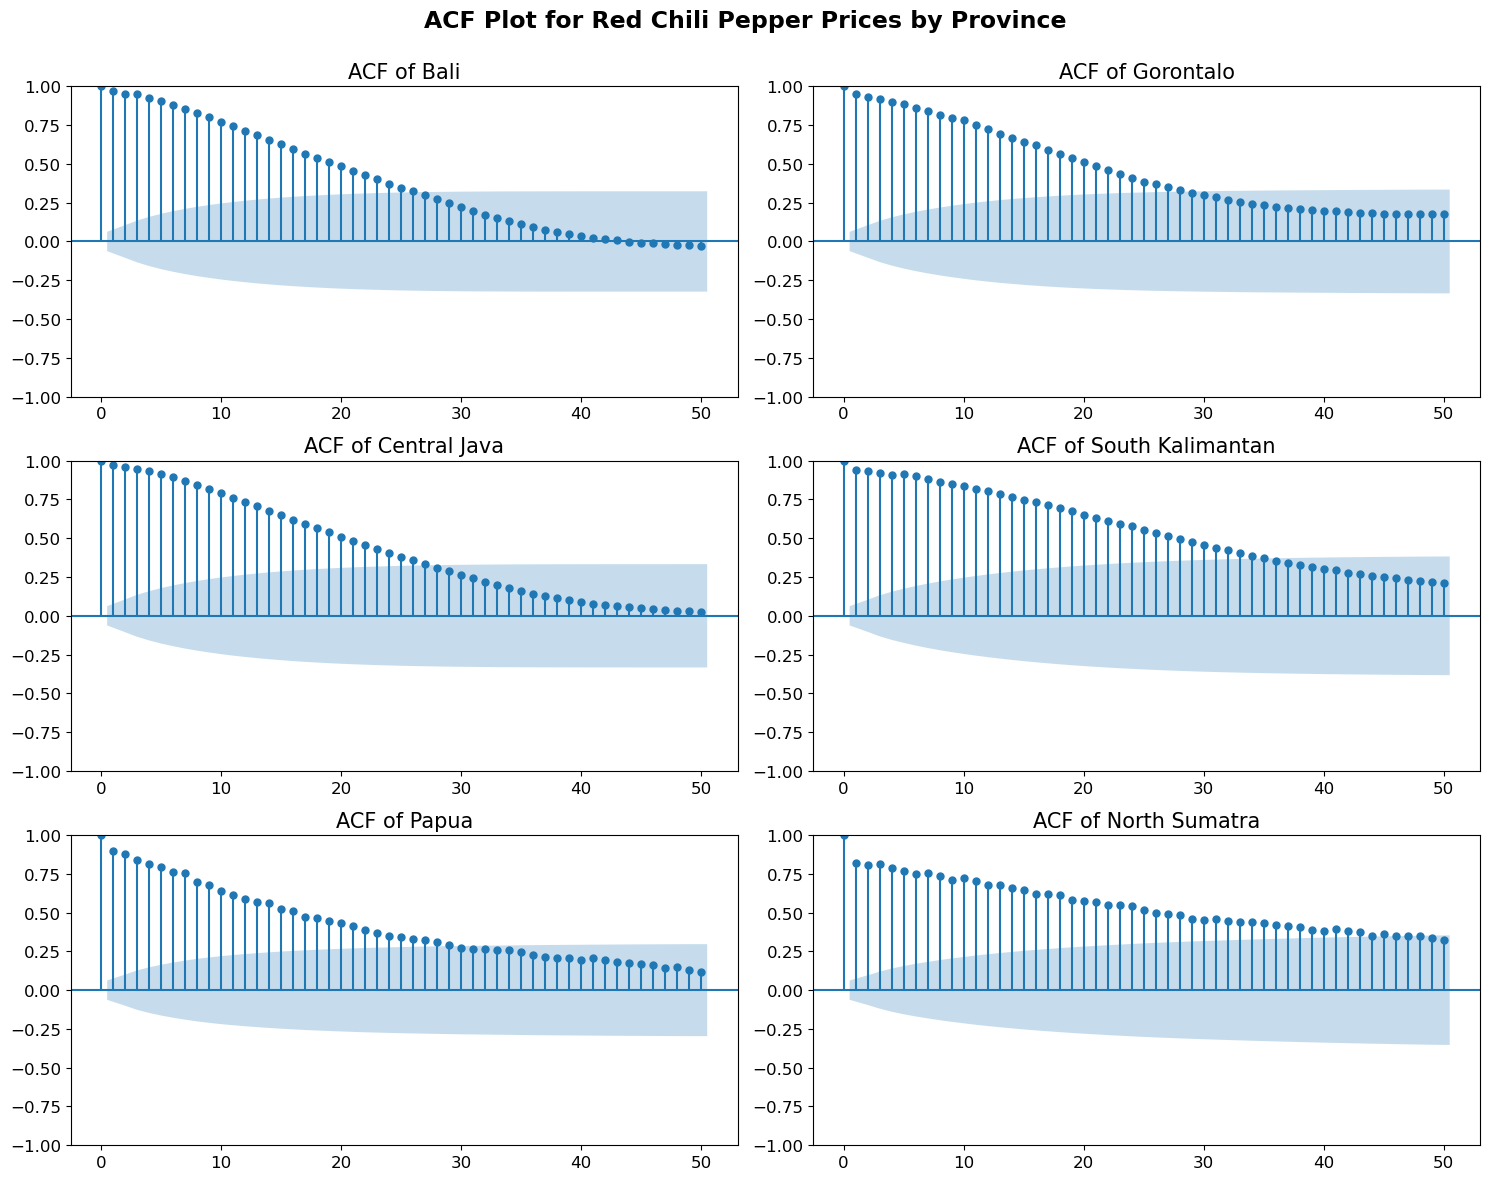

In [12]:
# ACF Plot used to check correlation of each province with its own past values (past time)
from statsmodels.graphics.tsaplots import plot_acf
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle("ACF Plot for Red Chili Pepper Prices by Province", fontsize=17, fontweight="bold")
axes = axes.flatten()

for i, region in enumerate(provinces):
    data = df_merged[region].dropna().astype(float)
    plot_acf(data, ax=axes[i], lags=50, title=f'ACF of {region}')
    axes[i].set_title(f'ACF of {region}', fontsize=15)
    axes[i].tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Insight:**
- Strong autocorrelation is observed at **short lags (<10 days)**, which gradually declines with increasing lag.  
- Significant correlation remains up to 25–40 days, then approaches an insignificant value (as seen in the ACF blue bars). This can help in determining the window size for the LSTM model.
- This indicates that **today’s price is still influenced by the past month’s prices**, though the effect decreases over time.

> Chili prices are strongly connected to their recent past, with today’s price still influenced by prices from the last few weeks, especially within about one month.

## **3. Data Cleaning & Preprocessing**

As identified in stage **2. Exploratory Data Analysis**, the conclusions are:  
- There are missing values in the middle of the data around July 2022, and at the beginning of the dataset.
- All data distributions are approximately normal.  
- All provinces contain outliers; however, these outliers follow the same pattern across provinces, suggesting they are part of the actual data pattern.
- Inter-province correlation is very strong for each time segment, except for Papua and North Sumatra.

Therefore, in this stage, the following steps will be carried out:
- Handle the sudden drop values that happens on 12th March 2021.
- Fill missing values using **linear interpolation** at the beginning of the dataset and **spline interpolation** in the middle of the dataset.
- Review the Line Chart graph after interpolation.
- Check ACF plot after interpolation
- Apply a **90:5:5** split, with **90% for training**, **5% for validation**, and **5% for testing**.
- Apply **Min-Max normalization** to standardize the data range across all provinces and avoid bias during the training of the MIMO LSTM model.  


### **3.1 Handle Sudden Drop Values**

In [13]:
# Handle the sudden drop values that happened on March 12, 2021 by multiplying the values by 10. This is based on observations indicating a system error on that date.
df_merged.loc[df_merged['Date'] == '2021-03-12', provinces] *= 10

### **3.2 Missing Values Imputation with Interpolation**

In [14]:
# Fill missing values using linear interpolation at the beginning of the dataset and spline interpolation in the middle of the dataset.
def handle_missing_with_interpolation(df):
    for col in df.columns[1:]:
        max_original = df[col].max()
        # Stage 1 Interpolation: Spline (fills missing values disconnected from data)
        df[col] = df[col].interpolate(method="spline", order=3)
        # Stage 2 Interpolation: Linear (fills remaining missing values, usually at the start of index)
        df[col] = df[col].interpolate(method="linear", limit_direction="both")
        # Limit the interpolated values to be within the range of 0 to max_original
        df[col] = df[col].clip(lower=0, upper=max_original)
    return df

df_merged_interpolated = handle_missing_with_interpolation(df_merged.copy())

df_merged_interpolated.info()
df_merged_interpolated

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036 entries, 0 to 1035
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              1036 non-null   datetime64[ns]
 1   Bali              1036 non-null   Float64       
 2   Gorontalo         1036 non-null   Float64       
 3   Central Java      1036 non-null   Float64       
 4   South Kalimantan  1036 non-null   Float64       
 5   Papua             1036 non-null   Float64       
 6   North Sumatra     1036 non-null   Float64       
dtypes: Float64(6), datetime64[ns](1)
memory usage: 62.9 KB


,Date,Bali,Gorontalo,Central Java,South Kalimantan,Papua,North Sumatra
0,2021-03-01,100000.0,80000.0,86000.0,130000.0,140000.0,32000.0
1,2021-03-02,100000.0,80000.0,86000.0,130000.0,140000.0,32000.0
2,2021-03-03,100000.0,80000.0,86000.0,130000.0,140000.0,32000.0
3,2021-03-04,100000.0,80000.0,86000.0,130000.0,140000.0,32000.0
4,2021-03-05,100000.0,80000.0,86000.0,130000.0,140000.0,32000.0
...,...,...,...,...,...,...,...
1031,2023-12-27,75420.0,129660.0,74910.0,75710.0,135340.0,73480.0
1032,2023-12-28,75240.0,124680.0,74410.0,64660.0,139290.0,68680.0
1033,2023-12-29,74430.0,121390.0,73660.0,67860.0,135190.0,66720.0
1034,2023-12-30,74850.0,117580.0,73170.0,63010.0,114200.0,57690.0


In [15]:
# Save cleaned dataset as CSV file
df_merged_interpolated.to_csv('dataset/processed/red_chili.csv', index=False)

### **3.3 Line Chart Visualization (after Interpolation)**

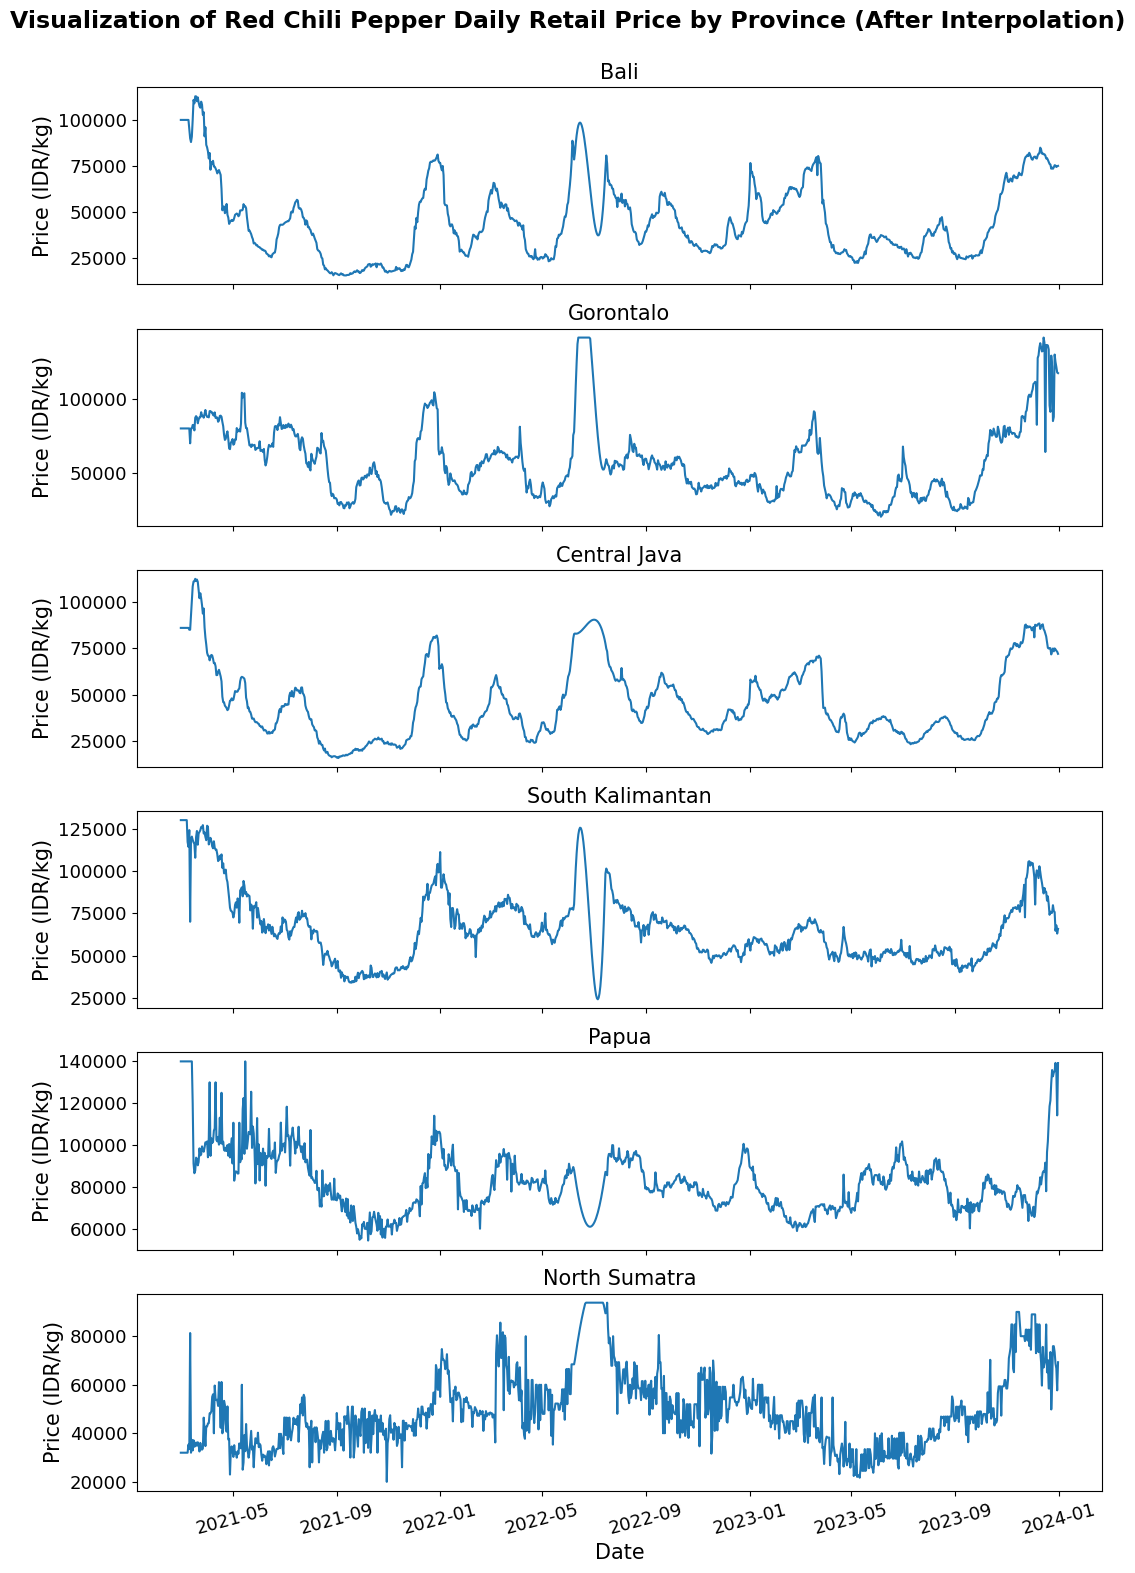

In [16]:
fig, axes = plt.subplots(6, 1, figsize=(11, 16), sharex=True)
fig.suptitle("Visualization of Red Chili Pepper Daily Retail Price by Province (After Interpolation)", fontsize=17, fontweight="bold")
for i, region in enumerate(provinces):
    axes[i].plot(df_merged_interpolated['Date'], df_merged_interpolated[region], label=region)
    axes[i].set_ylabel("Price (IDR/kg)", fontsize=15)
    axes[i].set_title(region, fontsize=15)
    axes[i].tick_params(axis="x", rotation=15, labelsize=13)
    axes[i].tick_params(axis="y", labelsize=13)
axes[-1].set_xlabel("Date", fontsize=15)
plt.subplots_adjust(hspace=0.5)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### **3.4 Data Split (90:5:5)**

In [17]:
# Apply a 90:5:5 time split, with 90% for training, 5% for validation, and 5% for testing.
train_size = int(len(df_merged_interpolated) * 0.8)
val_size = int(len(df_merged_interpolated) * 0.1)
test_size = len(df_merged_interpolated) - train_size - val_size

train_df = df_merged_interpolated.iloc[:train_size]
val_df = df_merged_interpolated.iloc[train_size:train_size + val_size]
test_df = df_merged_interpolated.iloc[train_size + val_size:]

### **3.5 Min-Max Normalization**

In [18]:
# Normalize the data using Min-Max Scaling
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[provinces])
val_scaled = scaler.transform(val_df[provinces])
test_scaled = scaler.transform(test_df[provinces])

## **4. MIMO LSTM Hyperparameter Tuning with Tree-Structured Parzen Estimator (TPE)**

As identified in stages **2. Exploratory Data Analysis** and **3. Data Cleaning & Preprocessing**, the significant lag (past value) for all provinces is found at values **≤ 40**. Therefore, this will define the TPE search space for the window size, ranging from 5 to 40 with a step of 5.  

The main architecture of the model consists of:  
- **Input**: With a shape of `(window_size, n_features)`, where `window_size` ranges from 5 to 40 and `n_features` corresponds to the number of provinces (6 in this case).  
- **LSTM Layer**: This layer will also be tuned, including the number of LSTM layers (from 1 to 3) and the number of neurons per layer (32, 64, or 128).  
- **Dense Layer**: A single dense layer is used as the final decision layer, with the number of neurons set as the search space (32, 64, or 128).  
- **Batch Size**: Search space values of 16, 32, or 64.  
- **Dropout Rate**: Search space between 0.1 and 0.5.  
- **Learning Rate**: Search space between 0.00001 and 0.001.  
- **Activation Functions**: *tanh* will be used for the LSTM layers, and *ReLU* will be applied to the Dense layer.  
- **Output**: With a shape of `(n_features,)`, representing the predicted prices for all provinces at the next time step.  


In [19]:
def create_mimo_dataset(data, window_size):
    # Create sequences data for MIMO Model
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :])
        y.append(data[i + window_size, :])
    return np.array(X), np.array(y)

def create_lstm_mimo_model(trial, n_features):
    # Define the hyperparameter search space and create the MIMO LSTM model
    window_size = trial.suggest_int('window_size', 5, 40, step=5)
    n_lstm_layers = trial.suggest_int('n_lstm_layers', 1, 3)
    n_lstm_units = []
    for i in range(n_lstm_layers):
        n_lstm_units.append(trial.suggest_categorical(f'n_lstm_units_layer_{i+1}', [32, 64, 128]))
    n_dense_units = trial.suggest_categorical('n_dense_units', [32, 64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    model = Sequential()
    for i in range(n_lstm_layers):
        return_seq = i < n_lstm_layers - 1
        if i == 0:
            model.add(LSTM(n_lstm_units[i], activation='tanh', return_sequences=return_seq, input_shape=(window_size, n_features)))
        else:
            model.add(LSTM(n_lstm_units[i], activation='tanh', return_sequences=return_seq))
        model.add(Dropout(dropout_rate))
    model.add(Dense(n_dense_units, activation='relu'))
    model.add(Dense(n_features)) 

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_absolute_error')
    return model, batch_size, window_size

def objective(trial, train_scaled, val_scaled, n_features):
    # Objective function for TPE to minimize validation loss (MSE)
    model, batch_size, window_size = create_lstm_mimo_model(trial, n_features)
    X_train, y_train = create_mimo_dataset(train_scaled, window_size)
    X_val, y_val = create_mimo_dataset(val_scaled, window_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=0)
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

def lstm_mimo_tpe_optimization(train_scaled, val_scaled, n_trials=50):
    # Perform hyperparameter optimization using Optuna's TPE sampler
    n_features = train_scaled.shape[1]
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(lambda trial: objective(trial, train_scaled, val_scaled, n_features), n_trials=n_trials, show_progress_bar=True)

    print(f"\nBest Hyperparameter : {study.best_params}")

    best_window_size = study.best_params['window_size']
    best_model, best_batch_size, _ = create_lstm_mimo_model(study.best_trial, n_features)
    X_full_train, y_full_train = create_mimo_dataset(np.concatenate([train_scaled, val_scaled]), best_window_size)
    early_stopping = EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)
    best_model.fit(
        X_full_train, y_full_train,
        epochs=200,
        batch_size=best_batch_size,
        callbacks=[early_stopping],
        verbose=0
    )

    return best_model, best_window_size

In [20]:
start_time = time.time()

best_model, best_window_size = lstm_mimo_tpe_optimization(train_scaled, val_scaled, n_trials=50)

end_time = time.time()
print(f'Tuning & Training Time: {end_time - start_time:.2f} seconds')

[I 2025-09-27 15:57:13,462] A new study created in memory with name: no-name-335cb102-a36f-4ed0-9330-4b487f3f793a


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-09-27 15:58:05,037] Trial 0 finished with value: 0.05098778009414673 and parameters: {'window_size': 15, 'n_lstm_layers': 3, 'n_lstm_units_layer_1': 32, 'n_lstm_units_layer_2': 128, 'n_lstm_units_layer_3': 64, 'n_dense_units': 32, 'dropout_rate': 0.17272998688284025, 'learning_rate': 3.5498788321965036e-05, 'batch_size': 32}. Best is trial 0 with value: 0.05098778009414673.
[I 2025-09-27 15:58:33,120] Trial 1 finished with value: 0.045259397476911545 and parameters: {'window_size': 15, 'n_lstm_layers': 2, 'n_lstm_units_layer_1': 128, 'n_lstm_units_layer_2': 64, 'n_dense_units': 64, 'dropout_rate': 0.34301794076057535, 'learning_rate': 3.247673570627447e-05, 'batch_size': 64}. Best is trial 1 with value: 0.045259397476911545.
[I 2025-09-27 15:59:16,998] Trial 2 finished with value: 0.03601912036538124 and parameters: {'window_size': 35, 'n_lstm_layers': 1, 'n_lstm_units_layer_1': 64, 'n_dense_units': 64, 'dropout_rate': 0.4637281608315128, 'learning_rate': 5.9750279999602906e-05

## **5. Model Evaluation**

### **5.1 Line Chart Forecast Result**

3/3 [==============================] - 0s 5ms/step
Bali -> MAE: 2342.19 - MSE: 8978403.24 - MAPE: 3.17%
Gorontalo -> MAE: 7753.80 - MSE: 280432855.08 - MAPE: 7.80%
Central Java -> MAE: 2780.20 - MSE: 12557093.02 - MAPE: 3.61%
South Kalimantan -> MAE: 4677.28 - MSE: 44698101.20 - MAPE: 5.92%
Papua -> MAE: 6045.75 - MSE: 95569425.45 - MAPE: 6.09%
North Sumatra -> MAE: 6900.77 - MSE: 71207715.69 - MAPE: 9.87%


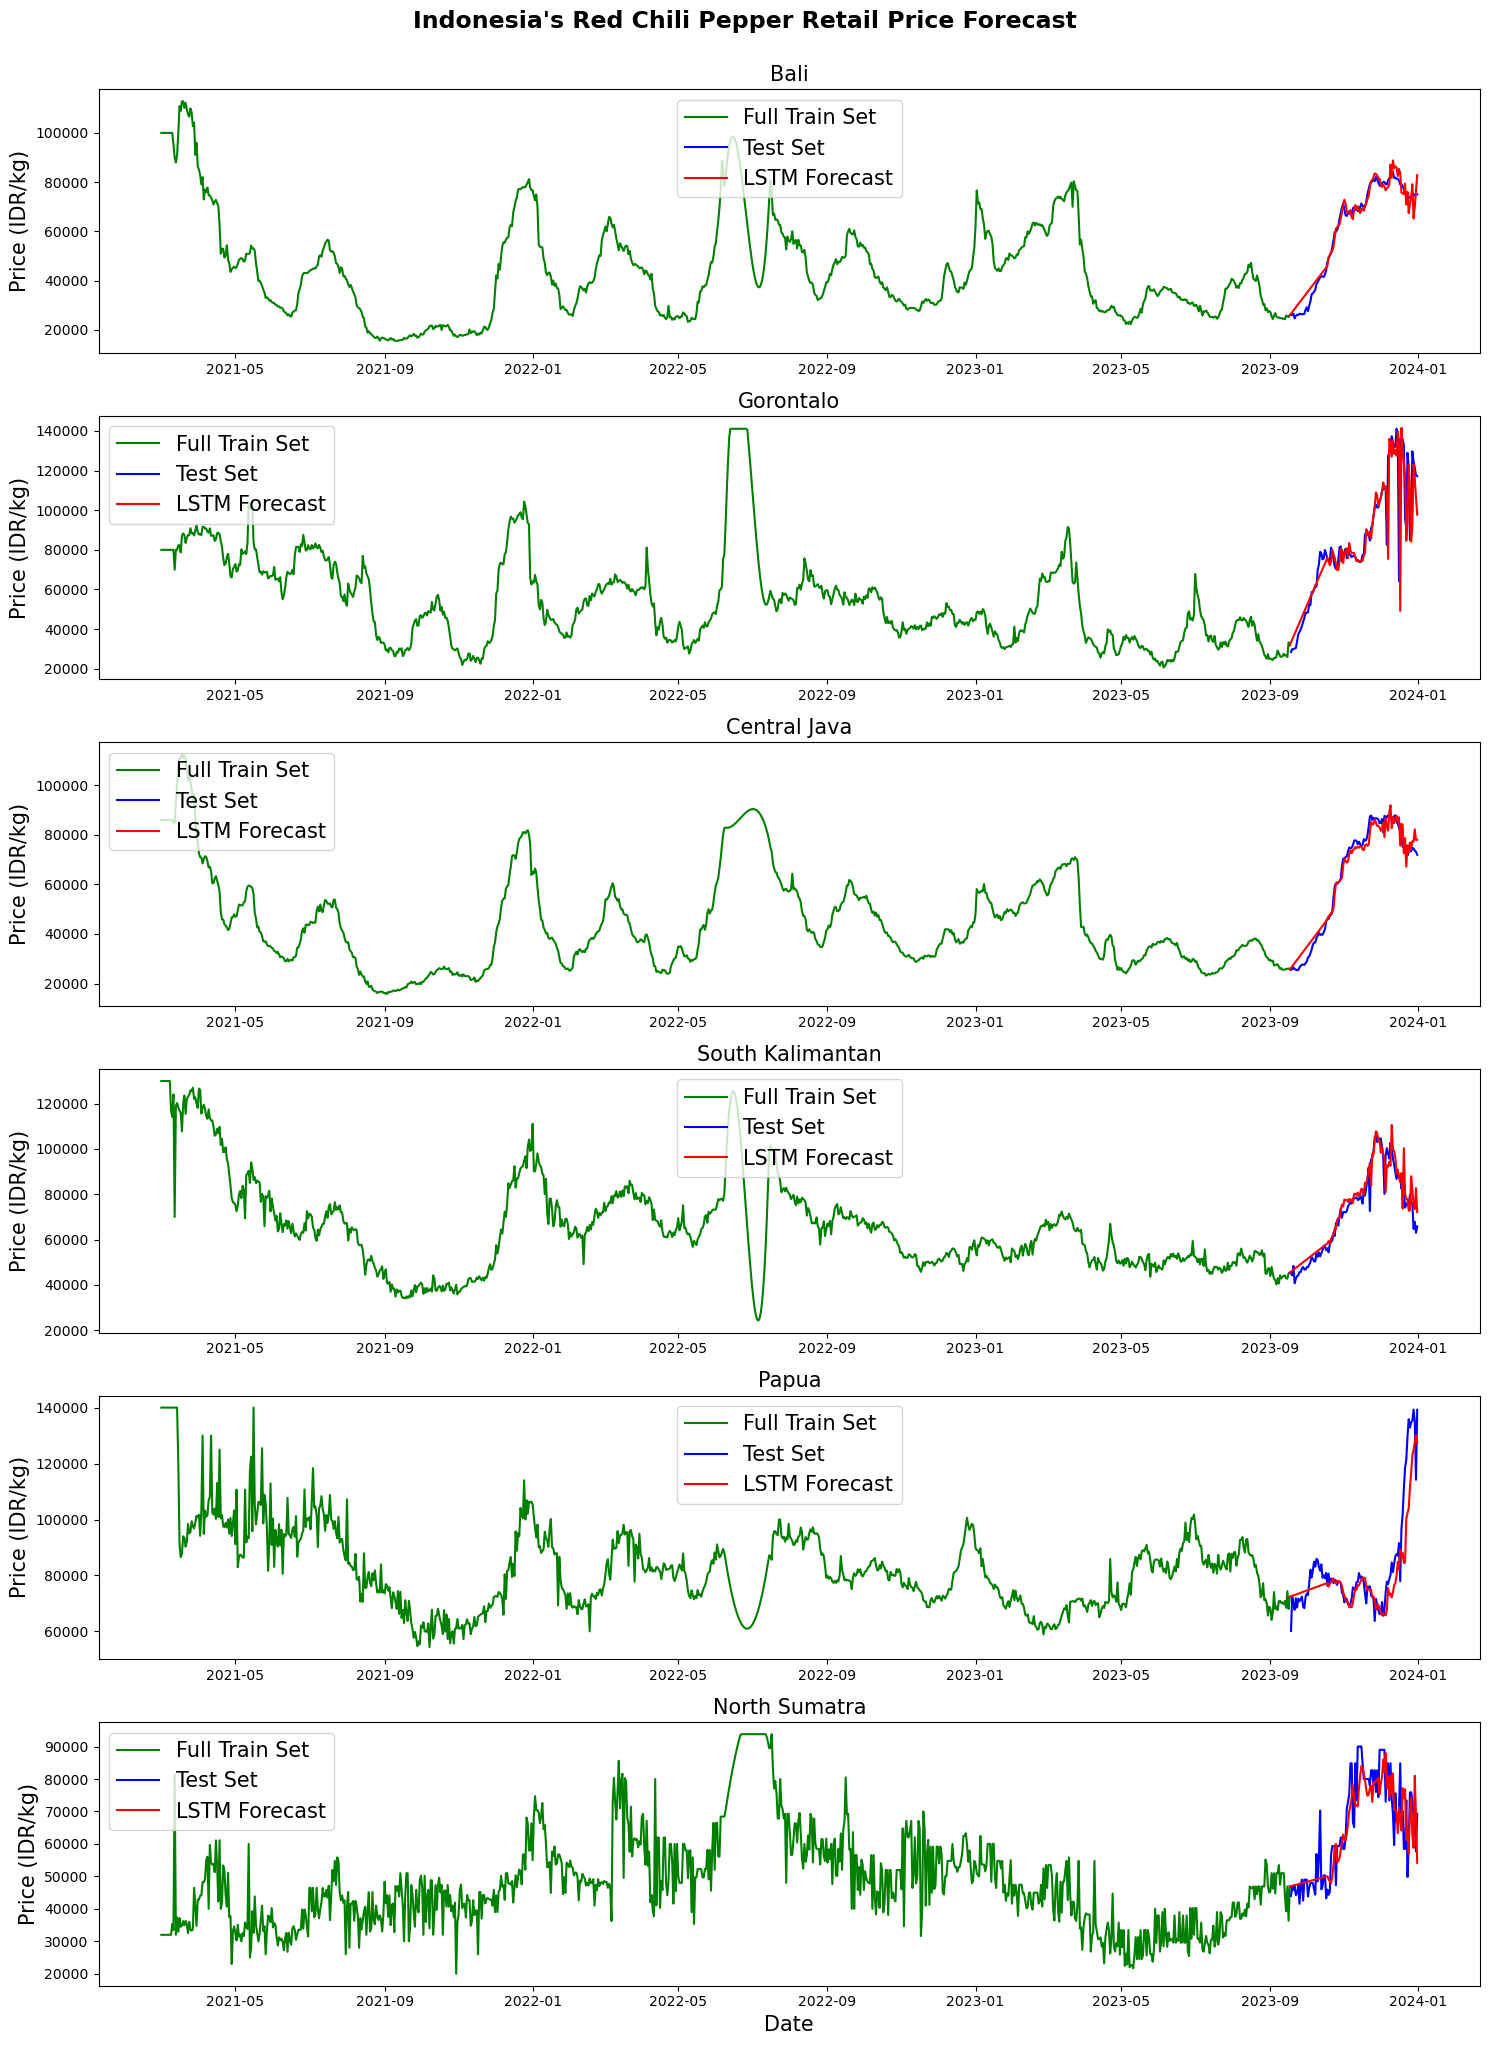

In [21]:
def plot_full_forecast(train_val_df, test_df, forecast_results, provinces):
    plt.figure(figsize=(15, 20))
    for i, region in enumerate(provinces):
        plt.subplot(len(provinces), 1, i+1)
        plt.plot(train_val_df['Date'], train_val_df[region], color='green', label='Full Train Set')
        plt.plot(test_df['Date'], test_df[region], color='blue', label='Test Set')
        full_dates = np.concatenate([train_val_df['Date'].values, test_df['Date'].values[-len(forecast_results):]])
        pred_series = np.concatenate([train_val_df[region].values[-1:], forecast_results[:, i]])
        plt.plot(full_dates[-len(pred_series):], pred_series, color='red', label='LSTM Forecast')
        plt.title(region, fontsize=15)
        plt.ylabel('Price (IDR/kg)', fontsize=15)
        if i == len(provinces)-1:
            plt.xlabel('Date', fontsize=15)
        plt.legend(fontsize=15)
    plt.tight_layout()
    plt.suptitle('Indonesia\'s Red Chili Pepper Retail Price Forecast', fontsize=17, fontweight='bold', y=1.02)
    plt.show()

# Create Full Final Train Set
train_val_df = pd.concat([train_df, val_df], ignore_index=True)

# Create test dataset and forecast results
X_test, y_test = create_mimo_dataset(test_scaled, best_window_size)
forecast_results = scaler.inverse_transform(best_model.predict(X_test))
y_test_original = scaler.inverse_transform(y_test)

# Print evaluation metrics on each province
mae_score = mean_absolute_error(y_test_original, forecast_results, multioutput='raw_values')
mse_score = mean_squared_error(y_test_original, forecast_results, multioutput='raw_values')
mape_score = mean_absolute_percentage_error(y_test_original, forecast_results, multioutput='raw_values')
for idx, region in enumerate(provinces):
    print(f"{region} -> MAE: {mae_score[idx]:.2f} - MSE: {mse_score[idx]:.2f} - MAPE: {mape_score[idx]:.2%}")

# Plot full forecast line chart
plot_full_forecast(train_val_df, test_df, forecast_results, provinces)


### **5.2 Line Chart Forecast Result (Test Set Only)**

Bali -> MAE: 2342.19 - MSE: 8978403.24 - MAPE: 3.17%
Gorontalo -> MAE: 7753.80 - MSE: 280432855.08 - MAPE: 7.80%
Central Java -> MAE: 2780.20 - MSE: 12557093.02 - MAPE: 3.61%
South Kalimantan -> MAE: 4677.28 - MSE: 44698101.20 - MAPE: 5.92%
Papua -> MAE: 6045.75 - MSE: 95569425.45 - MAPE: 6.09%
North Sumatra -> MAE: 6900.77 - MSE: 71207715.69 - MAPE: 9.87%


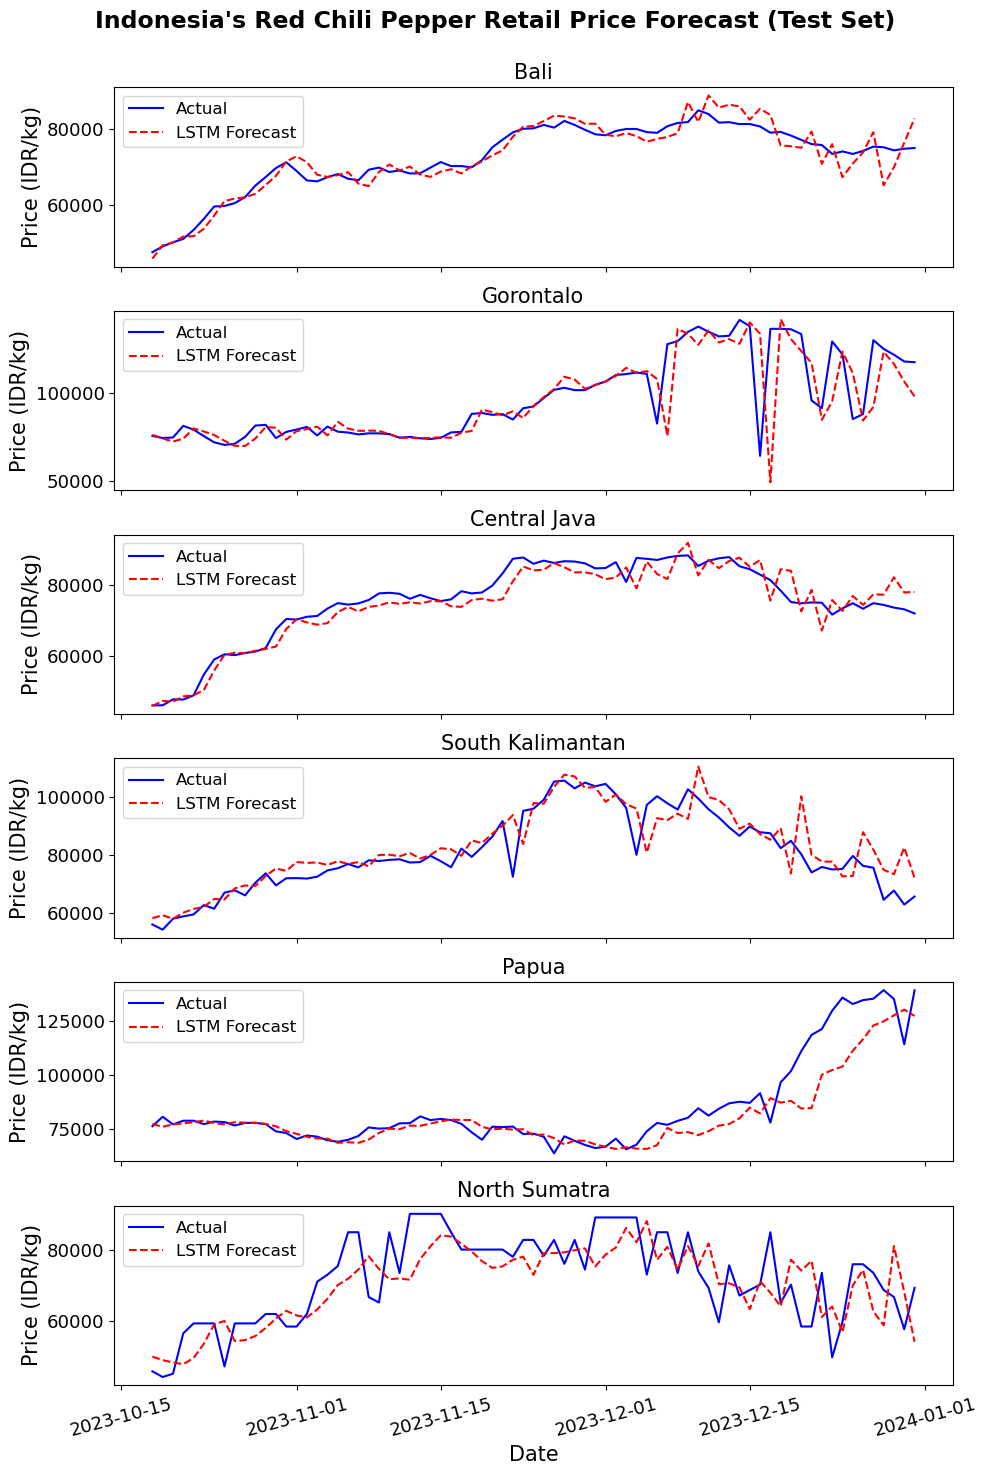

In [22]:
def plot_forecasts(y_test_original, forecast_results, provinces, test_df):
    fig, axes = plt.subplots(6, 1, figsize=(10, 15), sharex=True)
    fig.suptitle('Indonesia\'s Red Chili Pepper Retail Price Forecast (Test Set)', fontsize=17, fontweight='bold')
    dates = test_df['Date'].iloc[-len(y_test_original):]

    for i, region in enumerate(provinces):
        axes[i].plot(dates, y_test_original[:, i], label="Actual", color="blue")
        axes[i].plot(dates, forecast_results[:, i], label="LSTM Forecast", linestyle="--", color="red")
        axes[i].set_ylabel("Price (IDR/kg)", fontsize=15)
        axes[i].set_title(region, fontsize=15)
        axes[i].tick_params(axis="x", rotation=15, labelsize=13)
        axes[i].tick_params(axis="y", labelsize=13)
        axes[i].legend(fontsize=12)

    axes[-1].set_xlabel("Date", fontsize=15)
    plt.subplots_adjust(hspace=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

# Print evaluation metrics on each province
for idx, region in enumerate(provinces):
    print(f"{region} -> MAE: {mae_score[idx]:.2f} - MSE: {mse_score[idx]:.2f} - MAPE: {mape_score[idx]:.2%}")

# Line Chart for Actual vs Forecast on Test Set only
plot_forecasts(y_test_original, forecast_results, provinces, test_df)

The results of the **MIMO LSTM model** for forecasting Indonesia’s red chili pepper retail prices across six representative provinces show that the model is capable of capturing the seasonal and cyclical price movements, but its performance varies by region.

* **Bali and Central Java** demonstrate the best predictive accuracy with low MAPE (3.17% and 3.61%), indicating that the model effectively follows the actual price trends with only minor deviations.
* **South Kalimantan and Papua** show moderate performance (MAPE around 5.92%–6.09%), where the forecasts track the seasonal patterns but occasionally lag during sudden price changes.
* **Gorontalo and North Sumatra** record the weakest performance (MAPE 7.80% and 9.87%), with the forecasts struggling to adapt to high volatility and sharp fluctuations, especially in Gorontalo where extreme spikes are less accurately captured.

Overall, the model successfully generalizes the cyclical patterns across provinces, particularly in regions with stable trends (Bali, Central Java). However, for provinces with more irregular or volatile price dynamics (Gorontalo, North Sumatra), the model requires further refinement, possibly through hybrid approaches, feature enrichment, or better handling of sudden shocks.

These findings suggest that **MIMO LSTM is a promising method for forecasting chili pepper prices in Indonesia**, providing valuable insights for farmers, consumers, and policymakers. Nevertheless, additional adjustments are needed for regions with more volatile price movements to improve forecast reliability.

## **6. Model Export**

In [23]:
# Export Model and Scaler
best_model.save('model/mimo_lstm.h5')
joblib.dump(scaler, 'model/min-max-scaler.pkl')

# export best window size
with open('model/best_window_size.txt', 'w') as f:
    f.write(str(best_window_size))

# Export Forecast Results
forecast_df = pd.DataFrame(forecast_results, columns=provinces)
forecast_df['Date'] = test_df['Date'].iloc[-len(forecast_results):].values
forecast_df = forecast_df[['Date'] + provinces]
forecast_df.to_csv('dataset/forecast/red_chili_forecast.csv', index=False)

### Try to Import Model, Scaler, and Window Size

In [24]:
# Import model and scaler
best_model = load_model('model/mimo_lstm.h5')
scaler = joblib.load('model/min-max-scaler.pkl')

# Import best window size
with open('model/best_window_size.txt', 'r') as f:
    best_window_size = int(f.read().strip())

## **7. Conclution, Recomendation, & Future Work**


## **Conclusion**
This project uses a single **MIMO LSTM** model to forecast daily retail prices of red chili pepper across six representative Indonesian provinces. The model captures repeating seasonal cycles and shared patterns across regions, but forecast accuracy varies by province due to differences in volatility and data quality.

- **Highlight 1 — Seasonality:** Prices in all provinces show clear seasonal cycles and repeating ups-and-downs.  
- **Highlight 2 — Regional clustering:** Bali, Central Java, and South Kalimantan tend to move together (high correlation), while Papua and North Sumatra behave more independently.  
- **Highlight 3 — Model performance (MIMO LSTM):** The model performs best in **Bali** and **Central Java** (MAPE ≈ 3%), moderately in **South Kalimantan** and **Papua** (MAPE ≈ 6%), and worse in **Gorontalo** and **North Sumatra** (MAPE ≈ 8–10%).  
- **Highlight 4 — Outliers & spikes:** All provinces show occasional extreme price spikes (outliers) that are part of real market dynamics.  
- **Highlight 5 — Data quality:** There are missing-value gaps (notably around July 2022) and some suspicious sudden drops early in the series that need cleaning or verification.  

---

## **Recommendation**
**From Highlight 1 (Seasonality):**  
  - Farmers can schedule planting and harvesting to align with expected high-price periods.  
  - Traders and consumers can use simple seasonal awareness (buy/store before expected peaks).

**From Highlight 2 (Regional clustering):**  
  - Regional price monitoring and logistics coordination between correlated provinces (e.g., Java ↔ Kalimantan) can help dampen local shocks.

**From Highlight 3 (Model performance):**  
  - Use the MIMO LSTM forecast as a reliable guide in provinces with low MAPE (Bali, Central Java).  
  - For provinces with poorer accuracy (Gorontalo, North Sumatra), combine model output with local expert knowledge or add targeted monitoring.

**From Highlight 4 (Outliers & spikes):**  
  - Maintain contingency plans (buffer stocks, flexible supply routes) to handle sudden price spikes.  
  - Present forecast intervals/uncertainty to users, not just point estimates.

**From Highlight 5 (Data quality):**  
  - Improve data collection and validation at the source (reduce missing values and obvious anomalies).  
  - Adopt automated imputation + anomaly-detection pipelines before modeling.

---

## **Future Work**
- Incorporate weather, transport/logistics costs, holiday calendars, and input-cost indices to explain sudden shocks.  
- Experiment with a shared backbone + province-specific output heads (shared patterns + local tuning), or try attention/transformer variants.  
- Implement prediction intervals (e.g., via quantile loss, MC-dropout, or ensemble models) so stakeholders see forecast confidence.  
- Automated imputation (linear + spline), anomaly detection, and logging of data quality issues to reduce garbage-in/garbage-out.  
- For provinces that remain hard to predict, consider separate local models, transfer learning from high-data provinces, or higher-frequency data if available.  
- Build a simple dashboard for stakeholders, and set up a model performance monitor to trigger retraining when accuracy degrades.